# **Theoretical** **Part**

Indeed, matrix decompositions are often the workhorse algorithms for scientific computing applications in the areas of applied mathematics, statistical computing, and machine learning. Despite our ever-increasing computational power, the emergence of large-scale datasets has severely challenged our ability to analyze data using traditional matrix algorithms. Moreover, the growth of data collection is far outstripping computational performance gains. The computationally expensive singular value decomposition (SVD) is the most ubiquitous method for dimensionality reduction, data processing and compression. The concept of randomness has recently been demonstrated as an effective strategy to easing the computational demands of low-rank approximations from matrix decompositions such as the SVD, thus allowing for a scalable architecture for modern“big data” applications.

The basic idea of probabilistic matrix algorithms is to employ a degree of randomness in order to derive a smaller matrix from a high-dimensional matrix, which captures the essential information. Thus, none of the “randomness” should obscure the dominant spectral information of the data as long as the input matrix features some low-rank structure. Then, a deterministic matrix factorization algorithm is applied to the smaller matrix to compute a near-optimal low-rank approximation. The principal concept is sketched in Figure 1.
<img src="fig1.jpg" style="height:300px"> 

General Idea of the randomized algorithm
<br>
In the following, we advocate the probabilistic framework, formulated by Halko et al. (2011b), to compute a near-optimal low-rank approximation. Conceptually, this framework splits the computational task into two logical stages:
<br>
• Stage A: Construct a low dimensional subspace that approximates the column space of $A$. This means, the aim is to find a matrix $Q \in R^{m \times k}$ with orthonormal columns such that $A \approx QQ^T A$ is satisfied.
<br>
• Stage B: Form a smaller matrix $B=Q^T A \in R^{k \times n}$, i.e., restrict the high-dimensional
input matrix to the low-dimensional space spanned by the near-optimal basis $Q$. The
smaller matrix $B$ can then be used to compute a desired low-rank approximation.


Stage A: Computing the near-optimal basis
First, we aim to find a near-optimal basis Q for the matrix A such that $A \approx QQ^T A$ is satisfied. The desired target rank k is assumed to be $k << min{m, n}$. Specifically, P=QQT is a linear orthogonal projector.

The generic randomized algorithm

Stage A: Computing the near-optimal basis

First, we aim to find a near-optimal basis Q for the matrix A such that

$$A \approx QQ^T A$$

is satisfied. The desired target rank k is assumed to be k << min{m, n}. Specifically, P := QQ^T is a linear orthogonal projector. A projection operator corresponds to a linear subspace, and transforms any vector to its orthogonal projection on the subspace. This is illustrated in Figure, where a vector x is confined to the column space col(A).

<img src="fig2.jpg" style="height:300px">

Figure: Geometric illustration of the orthogonal projection operator P. A vector x ∈ $R^M$ is restricted to the column space of A, where Px ∈ col(A).

The concept of random projections can be used to sample the range (column space) of the input
matrix A in order to efficiently construct such a orthogonal projector. Random projections
are data agnostic, and constructed by first drawing a set of k random vectors ${ωi}^k$ i=1, for
instance, from the standard normal distribution. Probability theory guarantees that random
vectors are linearly independent with high probability. Then, a set of random projections
${yi}^k$ i=1 is computed by mapping A to low-dimensional space:

                         yi := Aωi for i = 1, 2, . . . , k.
In other words, this process forms a set of independent randomly weighted linear combinations of the columns of A, and reduces the number of columns from n to k. While the input matrix is compressed, the Euclidean distances between the original data points are approximately preserved. Random projections are also well known as the Johnson-Lindenstrauss (JL) transform (Johnson and Lindenstrauss 1984), and we refer to Ahfock, Astle, and Richardson (2017) for a recent statistical perspective.

Equation 3 can be efficiently executed in parallel. Therefore, let us define the random test matrix Ω ∈ Rn×k, which is again drawn from the standard normal distribution, and the columns of which are given by the vectors {ωi}. The samples matrix $Q \in R^{m \times k}$, also denoted as sketch, is then obtained by post-multiplying the input matrix by the random test matrix $$ Y := A\Omega $$
Once Y is obtained, it only remains to orthonormalize the columns in order to form a natural basis $Q \in R^{m \times k}$ This can be efficiently achieved using the QR-decomposition Y =: QR, and it follows that Equation 2 is satisfied.

Stage B: Compute the smaller matrix

Now, given the near-optimal basis Q, we aim to find a smaller matrix $B \in R^{k \times n}$. Therefore, we project the high-dimensional input matrix A to low-dimensional space $$B:= Q^*A$$
Geometrically, this is a projection (i.e., a linear transformation) which takes points in a high-dimensional space into corresponding points in a low-dimensional space, illustrated in


<img src="fig3.jpg" style="height:300px">


Figure 2: Points in a high-dimensional space are projected into low-dimensional space, while the geometric structure is preserved in an Euclidean sense.

This process preserves the geometric structure of the data in an Euclidean sense, i.e., the length of the projected vectors as well as the angles between the projected vectors are preserved. This is, due to the invariance of inner products (Trefethen and Bau 1997). Substituting Equation 5 into 2 yields then the following low-rank approximation

                         A     ≈    Q       B
                       m × n      m × k   k × n

This decomposition is referred to as the QB decomposition. Subsequently, the smaller matrix B can be used to compute a matrix decomposition using a traditional algorithm.










# **Comparison**

**FSVD and Standard SVD Differance**

In [2]:
"""input libraries """

from __future__ import absolute_import, division, print_function
import numpy.testing as npt
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from numpy.linalg import matrix_rank

In [3]:
"""Fast SVD"""



k = 150
def fsvd(A, k=k, i=1, usePowerMethod=1, **kwargs):    
    """takes an F-matrix and returns eigenvalues and eigenvectors of the ssvd method
    Based on algorithm described in 'An Algorithm for the Principal Component analysis
    of Large Data Sets' by N. Halko, P.G. Martinsson, Y. Shkolnisky, and M. Tygert
    and Matlab code: http://stats.stackexchange.com/questions/2806/best-pca-algorithm-for-huge-number-of-features
    
    F_matrix: F_matrix
    k: dimensions
    i: is the number of levels of the Krylov method to use, for most applications, i=1 or i=2 is sufficient
    userPowerMethod: changes the power of the spectral norm (minimizing the error).  
    """
    m, n = A.shape
    
    if m < n:
        A = A.T
    
    m, n = A.shape    #dimensions could have changed in above Transpose
    l = k + 2

    # entries independent, identically distributed Gaussian random variables of zero mean and unit variance
    G = np.random.standard_normal(size=(n, l))   
    if usePowerMethod == 1:
        H = np.dot(A, G)
        for x in range(i):
            H = np.dot(A, np.dot(A.T, H))   #enhance decay of singular values
    else:
        H = np.dot(A, G)
        tmp = np.dot(A, np.dot(A.T, H))
        H = np.hstack((H, np.dot(A, np.dot(A.T, H))))
        for x in range(i-1):
            H = np.hstack((H, np.dot(A, np.dot(A.T, tmp)))) ### tmp is currently undefined, inquiring
    
    Q, R = np.linalg.qr(H)    #pivoted QR-decomposition
    T = np.dot(A.T, Q) #step 3
    
    Vt, St, W = np.linalg.svd(T, full_matrices=False) #step 4 (as documented in paper)
    W = W.T
    
    Ut = np.dot(Q,W)

    if m < n:
        V_fsvd = Ut[:,:k]
        U_fsvd = Vt[:,:k]
    else:
        U_fsvd = Ut[:,:k]
        V_fsvd = Vt[:,:k]              
#     #drop imaginary component, if we got one
#     eigvals = (St[:k]**2).real
#     eigvecs = U_fsvd.real

#     return eigvals, eigvecs.T
    return U_fsvd, St[:k], V_fsvd

In [4]:
"""Creating a rank k random matrix"""

A = np.random.random((12000, 150)) @ np.random.random((150, 800))
print('Shape of random matrix : ',A.shape)
print('Rank of random matrix : ',matrix_rank(A))

Shape of random matrix :  (12000, 800)
Rank of random matrix :  150


In [5]:
"""Fast SVD on random matrix"""

U_A, st_A, V_A = fsvd(A, i=3, k=150, usePowerMethod=0)

A_hat = (U_A * st_A) @ V_A.T

In [6]:
print('Shape of random matrix Approximation: ',A_hat.shape)
print('rank of matrix Approximation: ',matrix_rank(A_hat))

Shape of random matrix Approximation:  (12000, 800)
rank of matrix Approximation:  150


In [7]:
"""Randomized SVD on random matrix"""

svd = randomized_svd(A, n_components = 150)
u, st_r, v = svd

A_r = (u * st_r) @ v

In [8]:
"""Full svd on random matrix"""

u, st_full, v = np.linalg.svd(A, full_matrices=False)
full_svd = (u * st_full) @ v

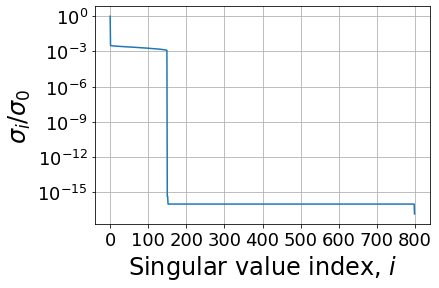

In [13]:
"""Fast SVD workes on the matrix which singular values decend fast"""
"""test to show our random matrix has/n't this criteria"""


plt.semilogy(st_full/st_full[0])
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)
# plt.savefig('Random matrix Singular value index.jpg')

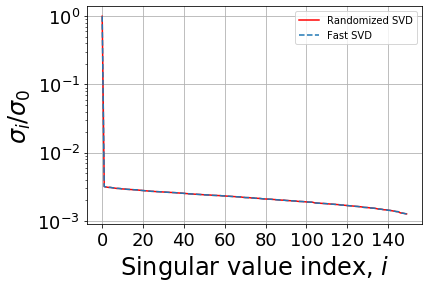

In [17]:
"""show that output of fast SVD and Randomized SVD still retain this criteria"""

plt.semilogy(st_r/st_r[0], 'r')
plt.semilogy(fsvd(A)[1]/fsvd(A)[1][0], '--')
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.legend(['Randomized SVD', 'Fast SVD'])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)
plt.savefig('fast & Randomized SVD of random matrix Singular value index.jpg')

In [18]:
"""Calculate the time taking to compute all three methods"""

print('time for randomized SVD : ')
%timeit randomized_svd(A, n_components = 150)
print('')
print('time for fast SVD : ')
%timeit fsvd(A, i=2, k=100, usePowerMethod=0)
print('')
print('time for SVD : ')
%timeit np.linalg.svd(A, full_matrices=False)

time for randomized SVD : 
11.7 s ± 1.95 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

time for fast SVD : 
8.59 s ± 1.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

time for SVD : 
20.7 s ± 1.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
"""Error for our approximations (Fast SVD and Randomized SVD) """

print('error for fsvd = ', np.linalg.norm((A - A_hat), 'fro'))        ## rank k approximation
print('error for rsvd = ',np.linalg.norm((A - A_r), 'fro'))          ## rank k approximation

error for fsvd =  6.852469613627421e-10
error for rsvd =  4.302644944580961e-10


# Test one a pictures:

In [20]:
"""Import an image"""

from PIL import Image
img = Image.open('10.jpg')

In [21]:
"""map 3D-image on 3D-array"""

import numpy as np
arr = np.array(img)
arr.shape

(825, 2440, 3)

In [22]:
"""make 2D-array"""

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
gray = rgb2gray(arr)
gray.shape

(825, 2440)

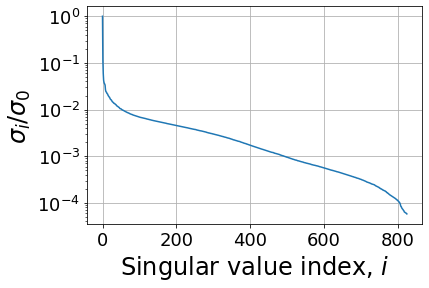

In [23]:
u, s, v = np.linalg.svd(gray, full_matrices=False)
svd = (u * s) @ v
plt.semilogy(s/s[0])
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)
plt.savefig('Image Singular value index.jpg')

In [24]:
U_gray, s_gray, V_gray = fsvd(gray, i=3, k=150, usePowerMethod=0)

fgray = (U_gray * s_gray) @ V_gray.T
fgray = fgray.T

In [25]:
print('Shape of image: ',fgray.shape)
print('Approximate rank of image: ',matrix_rank(fgray))

Shape of image:  (825, 2440)
Approximate rank of image:  150


In [26]:
U_r, s_r, V_r = randomized_svd(gray, n_components = 150)


rgray = (U_r * s_r) @ V_r

In [27]:
print('image randomized_svd Shape: ',fgray.shape)
print('Approximate image rank: ',matrix_rank(fgray))

image randomized_svd Shape:  (825, 2440)
Approximate image rank:  150


In [28]:
u_gray, s_gray, v_gray = np.linalg.svd(gray, full_matrices=False)
full_gray = (u_gray * s_gray) @ v_gray

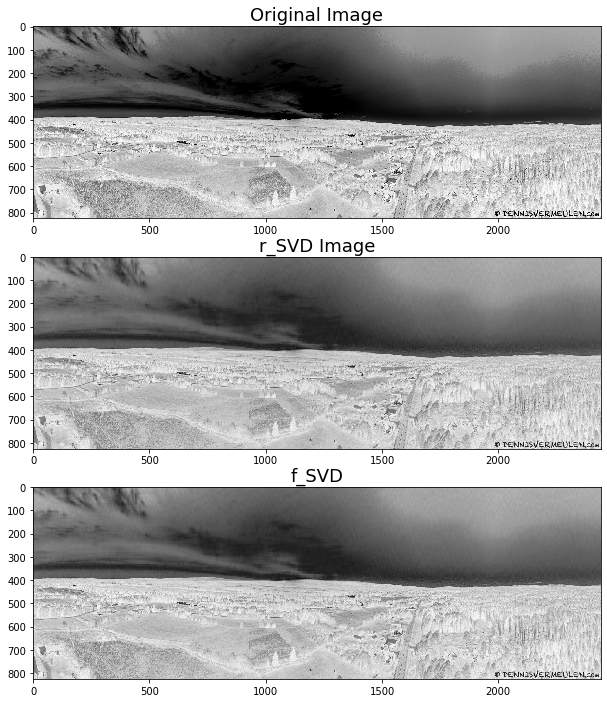

In [35]:
plt.subplot(3,1,1)
gray_plot = plt.imshow(gray,  cmap='Greys',  interpolation='nearest')
plt.title("Original Image", fontsize=18)
plt.subplot(3,1,2)
imgplot = plt.imshow(fgray, cmap='Greys',  interpolation='nearest')
plt.title("r_SVD Image", fontsize=18)
plt.subplot(3,1,3)
imgplot = plt.imshow(rgray,  cmap='Greys',  interpolation='nearest')
plt.title("f_SVD", fontsize=18)
fig = plt.gcf()
fig.set_size_inches(22, 12)
plt.show() 
# plt.savefig('Original Image #1.jpg')

In [30]:
print("error for fsvd = ", np.linalg.norm(gray - fgray, 'fro'))
print("error for rsvd = ", np.linalg.norm(gray - rgray, 'fro'))

error for fsvd =  12768.280938565827
error for rsvd =  12834.017598053088


In [31]:
print('time for randomized SVD : ')
%timeit randomized_svd(gray, n_components = 150)
print('')
print('time for fast SVD : ')
%timeit fsvd(gray, i=1, k=100, usePowerMethod=0)
print('')
print('time for SVD : ')
%timeit np.linalg.svd(gray, full_matrices=False)

time for randomized SVD : 
2.5 s ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

time for fast SVD : 
1.46 s ± 203 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

time for SVD : 
7.34 s ± 1.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## **Complexity**

1. RSVD: $O(mnlog(k) + (m+n)k^2)$ flops


2. Full SVD: $O(min(mn^2,m^2n))$


3. Truncated SVD:  $O(k^2m)$

# FSVD report


$\textbf{Introduction.}$

A is m × n, then we must find a positive integer k < min(m, n) and construct matrices U , Σ, and V such that:

$$A \approx U \Sigma V^T $$

with U being an m × k matrix whose columns are orthonormal, V being an n × k matrix whose columns are orthonormal, and Σ being a diagonal k × k matrix whose entries are all nonnegative.

The algorithm provided is most efficient when k is substantially less than min(m, n)

$$k \ll min(m, n)$$

The procedure of the present algorithm works to minimize the total number of times that has to access each entry of the matrix A being approximated.In our project, the entries of all matrices are real valued; our techniques extend trivially to matrices whose entries are complex valued.


$\textbf{Informal description of the algorithm.}$

Suppose that k, m, and n are positive integers with k < m and k < n, and A is a real m × n matrix. We will construct an approximation to A such that:

$$\|A - U \Sigma V^T\|_2 \approx \sigma_{k+1}$$

where U is a real m × k matrix whose columns are orthonormal, V is a real n × k matrix whose columns are orthonormal, Σ is a diagonal real k×k matrix whose entries are all nonnegative,$\|A - U \Sigma V^T\|_2 $
is the spectral ($l^2$ -operator) norm of $A − U Σ V^⊤$ , and $\sigma_{k+1}$ is the (k + 1)st greatest singular value of A.we select nonnegative integers i and l such that $l \ge k$ and $(i + 2)k \le n$ (for most applications, l = k + 2 and $i \ge 2$ is sufficient.Then identify an orthonormal basis for “most” of the range of A via the following two steps:

1_ Using a random number generator, form a real $n × l$ matrix $G$ whose entries are independent and identically distributed Gaussian random variables of zero mean and unit variance, and compute the $m × ((i + 1)l)$ matrix

$$H = (A G | A A^⊤ A G |. . .| (A A ⊤ )^{i−1} A G | (A A^⊤ )^i A G)$$

2_ Using a pivoted $QR$-decomposition, form a real $m × ((i + 1)l)$ matrix $Q$ whose columns are orthonormal, such that there exists a real $((i + 1)l) × ((i + 1)l)$ matrix $R$ for which

$$H = QR$$

Notice that Q may have many fewer columns than $A$, that is, $k$ may be substantially less than $n$ (this is the case for most applications of principal component analysis). This is the key to the efficiency of the algorithm.

Having identified a good approximation to the range of $A$, we perform some simple linear algebraic manipulations in order to obtain a good approximation to $A$, via the following four steps:

3_ Compute the $n × ((i + 1)l)$ product matrix

$$T = A^T Q$$

4_ From an SVD of T

$$T = V' \Sigma' W'^T$$

5- Compute the $m × ((i + 1)l)$ product matrix

$$U' = QW$$

6_ Retrieve the leftmost $m × k$ block $U$ of $U'$ , the leftmost $n × k $block $V$ of $V'$ , and the leftmost uppermost $k × k$ block $\Sigma$ of $\Sigma'$.